# Figure Eight: Medical Sentence Summary

## https://www.kaggle.com/kmader/figure-eight-medical-sentence-summary

*I didn't find a dataset that mer all of the requirements on archive.ics so I picked one from Kaggle

### 1. Loading the dataset

In [1]:
rdd = sc.textFile('medical.csv')
header = rdd.first()
print len(header.split(',')), 'columns'
rdd = rdd.filter(lambda line: line != header)

24 columns


### 2. Transforming the data to RDD pairs

In [2]:
pairs = rdd.map(lambda x: (x.split(",")[0], x.split(",")[1:]))
print pairs.count(), 'rows'

13340 rows


In [3]:
pairs.first()

(u'502808352',
 [u'7/13/14 13:48',
  u'',
  u'1321892767',
  u'clixsense',
  u'0.9167',
  u'27871219',
  u'NLD',
  u'7',
  u'Amsterdam',
  u'87.210.207.223',
  u'IM CEFTRIAXONE treats URETHRAL OR RECTAL GONORRHEA',
  u'41',
  u'128',
  u'',
  u'69',
  u'142',
  u'treats',
  u'1',
  u'907845-FS1-2',
  u'"For treatment of uncomplicated cervical',
  u' URETHRAL OR RECTAL GONORRHEA CDC and others recommend IM ceftriaxone or oral cefixime; IM CEFTRIAXONE is drug of choice for pharyngeal infections."',
  u'URETHRAL OR RECTAL GONORRHEA',
  u'IM CEFTRIAXONE',
  u'RO-may_treat'])

### 3.a Counting distinct values

In [4]:
print 'Channel', pairs.map(lambda x: (x[1][3])).countApproxDistinct(), 'distinct values'
print 'Trust', pairs.map(lambda x: (x[1][4])).countApproxDistinct(), 'distinct values'
print 'Country', pairs.map(lambda x: (x[1][6])).countApproxDistinct(), 'distinct values'
print 'City', pairs.map(lambda x: (x[1][8])).countApproxDistinct(), 'distinct values'
print 'Relation', pairs.map(lambda x: (x[1][16])).countApproxDistinct(), 'distinct values'

Channel 39 distinct values
Trust 881 distinct values
Country 5 distinct values
City 420 distinct values
Relation 10 distinct values


### 3.b Distributions

In [5]:
import matplotlib
import matplotlib.pyplot as plt

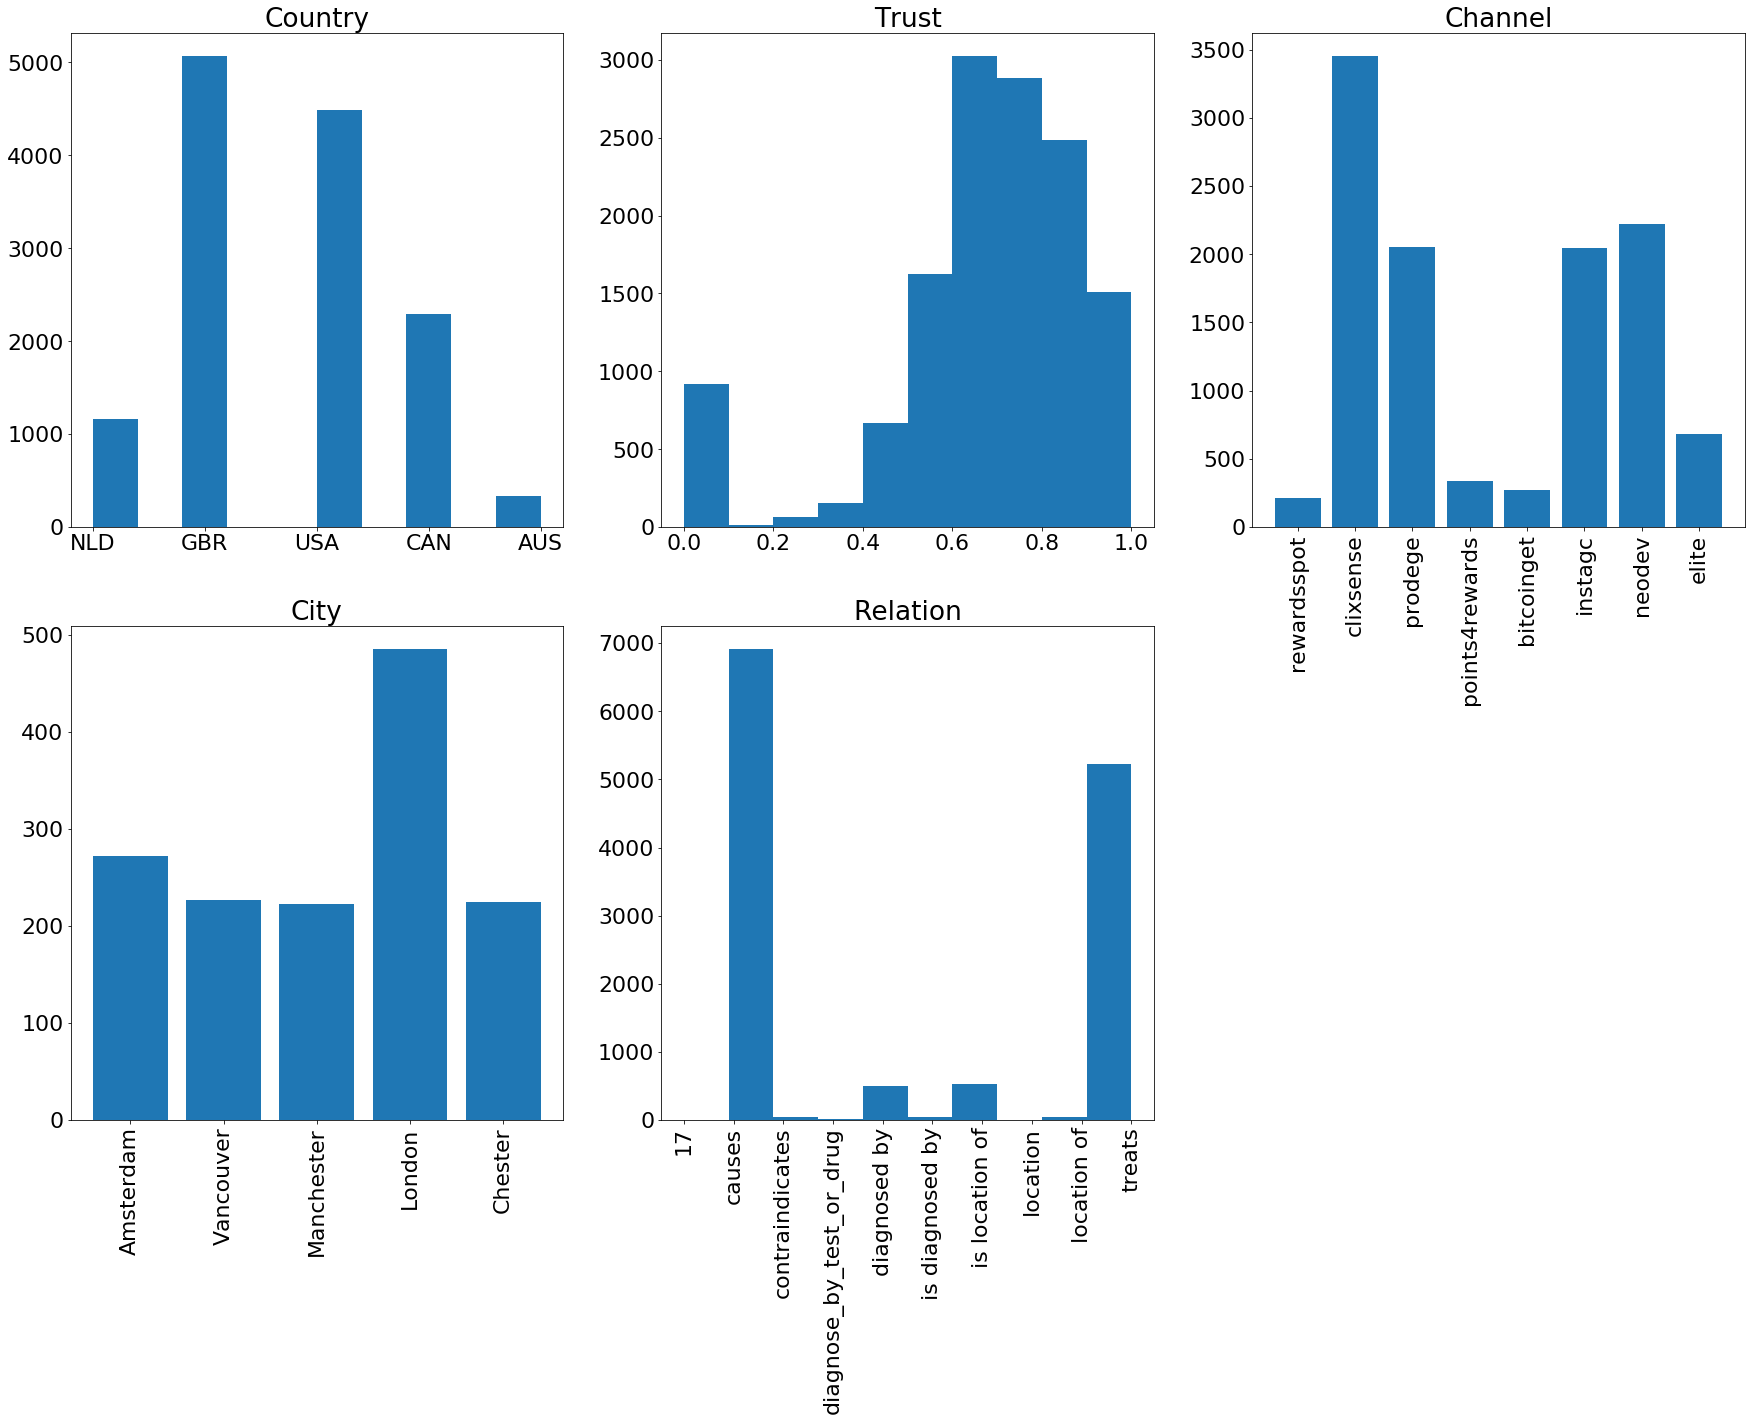

In [6]:
matplotlib.rcParams.update({'font.size': 22})

ax = plt.subplot(2,3,1)
ax.set_title('Country')
ax.hist(pairs.map(lambda x: (x[1][6])).collect())

ax = plt.subplot(2,3,2)
ax.set_title('Trust')
ax.hist(pairs.map(lambda x: float((x[1][4]))).collect())

ax = plt.subplot(2,3,3)
ax.set_title('Channel')
filtered = { k: v for k,v in pairs.map(lambda x: (x[1][3])).countByValue().iteritems() 
            if k <> '' and v > 200 }
ax.bar(filtered.keys(), filtered.values())
plt.xticks(rotation=90)
ax.figure.set_size_inches(30, 20)

ax = plt.subplot(2,3,4)
ax.set_title('City')
filtered = { k: v for k,v in pairs.map(lambda x: (x[1][8])).countByValue().iteritems() 
            if k <> '' and v > 200 }
ax.bar(filtered.keys(), filtered.values())
plt.xticks(rotation=90)

ax = plt.subplot(2,3,5)
ax.set_title('Relation')
ax.hist(pairs.map(lambda x: (x[1][16])).sortBy(lambda x: x).collect())
plt.xticks(rotation=90)

plt.show() 

### 3.c Explaining the results

It's easy to see that UK is the most popular country in the dataset and London is the most seen city. The relations field in the show that "causes" and "treats" are the most common relations and that trust with the doctor is on average between 0.6 and 0.8.

### 4. Filling in missing values

In [7]:
# TODO

### 5. Transforming categorical to numerical features

In [8]:
from sklearn import preprocessing

# transform Country
le = preprocessing.LabelEncoder()
le.fit(pairs.map(lambda x: (x[1][6])).collect())
pairs = pairs.map(lambda x: (x[0], x[1] + [unicode(le.transform([x[1][6]])[0])]))

# transform Relation
le2 = preprocessing.LabelEncoder()
le2.fit(pairs.map(lambda x: (x[1][16])).collect())
pairs = pairs.map(lambda x: (x[0], x[1] + [unicode(le2.transform([x[1][16]])[0])]))

pairs.first()

(u'502808352',
 [u'7/13/14 13:48',
  u'',
  u'1321892767',
  u'clixsense',
  u'0.9167',
  u'27871219',
  u'NLD',
  u'7',
  u'Amsterdam',
  u'87.210.207.223',
  u'IM CEFTRIAXONE treats URETHRAL OR RECTAL GONORRHEA',
  u'41',
  u'128',
  u'',
  u'69',
  u'142',
  u'treats',
  u'1',
  u'907845-FS1-2',
  u'"For treatment of uncomplicated cervical',
  u' URETHRAL OR RECTAL GONORRHEA CDC and others recommend IM ceftriaxone or oral cefixime; IM CEFTRIAXONE is drug of choice for pharyngeal infections."',
  u'URETHRAL OR RECTAL GONORRHEA',
  u'IM CEFTRIAXONE',
  u'RO-may_treat',
  u'3',
  u'9'])

### 6. Transforming timestamp to categorical features

In [9]:
# add hour
pairs = pairs.map(lambda x: (x[0], x[1] + [x[1][0].split(' ')[1]]))
# add day
pairs = pairs.map(lambda x: (x[0], x[1] + [x[1][0].split('/')[1]]))
# add month
pairs = pairs.map(lambda x: (x[0], x[1] + [x[1][0].split('/')[0]]))

pairs.first()

(u'502808352',
 [u'7/13/14 13:48',
  u'',
  u'1321892767',
  u'clixsense',
  u'0.9167',
  u'27871219',
  u'NLD',
  u'7',
  u'Amsterdam',
  u'87.210.207.223',
  u'IM CEFTRIAXONE treats URETHRAL OR RECTAL GONORRHEA',
  u'41',
  u'128',
  u'',
  u'69',
  u'142',
  u'treats',
  u'1',
  u'907845-FS1-2',
  u'"For treatment of uncomplicated cervical',
  u' URETHRAL OR RECTAL GONORRHEA CDC and others recommend IM ceftriaxone or oral cefixime; IM CEFTRIAXONE is drug of choice for pharyngeal infections."',
  u'URETHRAL OR RECTAL GONORRHEA',
  u'IM CEFTRIAXONE',
  u'RO-may_treat',
  u'3',
  u'9',
  u'13:48',
  u'13',
  u'7'])

### 7. Normalizing numerical columns

In [10]:
from pyspark.mllib.feature import Normalizer

temp = pairs.join(sc.parallelize(zip(pairs.map(lambda x: x[0]).collect(), 
                                      Normalizer().transform(pairs.map(lambda x: float((x[1][4]))).collect()))))
pairs = temp.map(lambda x: (x[0], x[1][0] + [x[1][1]]))

pairs.first()

(u'498010593',
 [u'7/4/14 12:22',
  u'FALSE',
  u'1314824452',
  u'clixsense',
  u'1',
  u'15189335',
  u'GBR',
  u'I9',
  u'Dereham',
  u'86.157.163.112',
  u'MIGRAINE causes HEADACHE',
  u'148',
  u'89',
  u'',
  u'156',
  u'97',
  u'causes',
  u'0.461880215',
  u'904938-FS1-4',
  u'The effect was manifested in complete relief in six patients treated during an attack of MIGRAINE and in a relatively high number of other cases of HEADACHE with relief of pain',
  u'HEADACHE',
  u'MIGRAINE',
  u'RO-has_definitional_manifestation',
  u'2',
  u'1',
  u'12:22',
  u'4',
  u'7',
  0.012188572329373183])

### 8. Transforming text features

#### 8.a Tokenizing

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

tokenized = sc.parallelize(zip(pairs.map(lambda x: x[0]).collect(), 
                               CountVectorizer().fit_transform(pairs.map(lambda x: (x[1][19])).collect())))

#### 8.b Removing stop words

In [12]:
from pyspark.ml.feature import StopWordsRemover

# remover = StopWordsRemover(inputCol="raw", outputCol="filtered")
# remover.transform(pairs.toDF()).show(truncate=False)

#TODO - use df?

#### 8.c Vectorizing to binary

In [13]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(np.array(pairs.map(lambda x: (x[1][19])).collect()).reshape(-1, 1))
pairs = pairs.map(lambda x: (x[0], x[1] + [enc.transform(np.array(x[1][19])
                                                         .reshape(-1, 1)).toarray().tolist()]))

pairs.first()

(u'498010593',
 [u'7/4/14 12:22',
  u'FALSE',
  u'1314824452',
  u'clixsense',
  u'1',
  u'15189335',
  u'GBR',
  u'I9',
  u'Dereham',
  u'86.157.163.112',
  u'MIGRAINE causes HEADACHE',
  u'148',
  u'89',
  u'',
  u'156',
  u'97',
  u'causes',
  u'0.461880215',
  u'904938-FS1-4',
  u'The effect was manifested in complete relief in six patients treated during an attack of MIGRAINE and in a relatively high number of other cases of HEADACHE with relief of pain',
  u'HEADACHE',
  u'MIGRAINE',
  u'RO-has_definitional_manifestation',
  u'2',
  u'1',
  u'12:22',
  u'4',
  u'7',
  0.012188572329373183,
  [[0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
 

#### 8.a Tokenizing - Continue

In [14]:
pairs = pairs.join(tokenized).map(lambda x: (x[0], x[1][0] + [x[1][1].toarray().tolist()]))

pairs.first()

(u'497984437',
 [u'7/4/14 10:28',
  u'',
  u'1314760915',
  u'clixsense',
  u'0.8875',
  u'19162475',
  u'GBR',
  u'M3',
  u'Frome',
  u'82.33.126.30',
  u'no_relation',
  u'37',
  u'52',
  u'',
  u'50',
  u'69',
  u'causes',
  u'0.657595949',
  u'906444-FS1-4',
  u'A few cases of AIDS have occurred in HAEMOPHILIA B (CHRISTMAS DISEASE) patients',
  u'HAEMOPHILIA B',
  u'CHRISTMAS DISEASE',
  u'RO-has_manifestation',
  u'2',
  u'1',
  u'10:28',
  u'4',
  u'7',
  0.0108173579423187,
  [[0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
 